In [1]:
from torch.utils.data import DataLoader
from ty_datasets import PoseDataset, TrackingDataset
from ref_dataset import ReferenceDataset, SimTestDataset
from matcher import Dinov2Matcher
from utils.spd import sample_points_from_mesh

B = 1
shuffle = False
device = 'cuda:1'

vis_dataset = PoseDataset() # sample
vis_dataset = SimTestDataset()
ref_dataset = ReferenceDataset(dataset_location="/root/autodl-tmp/shiqian/code/gripper/render_lowres")      # 用于matcher的refs
vis_dataloader = DataLoader(vis_dataset, batch_size=B, shuffle=shuffle)
ref_dataloader = DataLoader(ref_dataset, batch_size=1, shuffle=shuffle)
iterloader = iter(vis_dataloader)
refs = next(iter(ref_dataloader))

global_step = 0
gripper_path = "/root/autodl-tmp/shiqian/code/gripper/franka_hand_obj/franka_hand.obj"
gripper_pointcloud = sample_points_from_mesh(gripper_path, n_pts=8192)
matcher = Dinov2Matcher(refs=refs, model_pointcloud=gripper_pointcloud, half_precision=False)


Loading pose estimation dataset...
Found 9 videos in /root/autodl-tmp/shiqian/datasets/Ty_data
Loading reference view dataset...
Found 64 views in /root/autodl-tmp/shiqian/code/gripper/render_random
Loading reference view dataset...
Found 64 views in /root/autodl-tmp/shiqian/code/gripper/render_lowres
(64, 180, 320, 3)
Calculating reference view features...


In [2]:
import torch
sample = next(iterloader)

metrics = {}

rgbs = torch.Tensor(sample['rgb']).float().permute(0, 3, 1, 2).to(device) # B, C, H, W
depths = torch.Tensor(sample['depth']).float().permute(0, 3, 1, 2).to(device)
masks = torch.Tensor(sample['mask']).float().permute(0, 3, 1, 2).to(device)
#kptss = sample['kpts']
#npys = sample['npy']
#intrinsics = sample['intrinsics']

images = torch.concat([rgbs, depths[:,0:1], masks[:,0:1]], axis = 1)
# matches_3d = matcher.match_and_fuse(images)  # N, 6 部分实际图中的点 及 算出来的模型中相似度最高的对应点云的坐标

In [18]:
from torchmetrics.functional import pairwise_cosine_similarity, pairwise_euclidean_distance
import torch.nn.functional as F
from utils.spd import get_2dbboxes, create_3dmeshgrid, transform_batch_pointcloud_torch
from utils.spd import save_pointcloud, transform_pointcloud_torch, project_points, calc_coords_3d_var
import math

B, C, H, W = images.shape
N_refs, feat_C, feat_H, feat_W = matcher.ref_features.shape    # N_refs个视角渲染的特征,直接用预训练好的dinoV2模型
assert(feat_H == feat_W)
feat_size = feat_H
cropped_rgbs, cropped_masks, bboxes = matcher.prepare_images(images)   # 裁一下
features = matcher.extract_features(cropped_rgbs) # B, 1024, 32, 32    #
N_tokens = feat_H * feat_W
features = features.permute(0, 2, 3, 1).reshape(-1, feat_C) # B*N, C
ref_features = matcher.ref_features.permute(0, 2, 3, 1).reshape(-1, feat_C) # N_refs*N, C
cosine_sims = pairwise_cosine_similarity(features, ref_features) # B*N, 32*N    # 渲染N_refs个视角后，对实际图的所有patch和渲染视角的patch求相似度，试图找出相似度最高的点
cosine_sims = cosine_sims.reshape(B, N_tokens, N_refs, N_tokens) # B, 1024, 32, 1024    前面是实际，后面是渲染
cosine_sims = cosine_sims.reshape(B, feat_H, feat_W, N_refs, feat_H, feat_W) # B, 32, 32, Nref, 32, 32
batch_feat_masks = F.interpolate(cropped_masks, size=(feat_H, feat_W), mode = "nearest") # B, 1, 32, 32  resize裁剪后实际图的mask

cosine_sims = cosine_sims[batch_feat_masks[:,0] > 0]    # 取实际图的mask
cosine_sims = cosine_sims[:, matcher.feat_masks[:,0] > 0]  # 取渲染图的mask
test_idxs = create_3dmeshgrid(B, feat_H, feat_W, matcher.device)
ref_idxs = create_3dmeshgrid(N_refs, feat_H, feat_W, matcher.device)
test_idxs = test_idxs[batch_feat_masks[:,0] > 0]    # 对实际图mask后，剩下的patch的坐标
ref_idxs = ref_idxs[matcher.feat_masks[:,0] > 0]       # 对渲染图mask后，剩下的patch的坐标

test_2d_coords = matcher.idx_to_2d_coords(test_idxs, bboxes) # N_test_2d_pts, 3    还原到原图像中的位置
ref_2d_coords = matcher.idx_to_2d_coords(ref_idxs, matcher.ref_bboxes)
ref_3d_coords = matcher.coords_2d_to_3d(ref_2d_coords, matcher.ref_images[:,3], matcher.ref_intrinsics, matcher.ref_c2os)   # 找到参考图中的点，在三维模型中的位置

print(ref_3d_coords.shape)

ref_valid_idxs = torch.logical_and(ref_3d_coords[:,1]<10, ref_3d_coords[:,1]>-10) # ref的三维坐标在-1到1之间？
ref_valid_idxs = torch.logical_and(ref_valid_idxs, ref_3d_coords[:,2]<10)
ref_valid_idxs = torch.logical_and(ref_valid_idxs, ref_3d_coords[:,2]>-10)
ref_valid_idxs = torch.logical_and(ref_valid_idxs, ref_3d_coords[:,3]<10)
ref_valid_idxs = torch.logical_and(ref_valid_idxs, ref_3d_coords[:,3]>-10)

cosine_sims = cosine_sims[:, ref_valid_idxs] # N_test_2d_pts, N_3d_ref_pts 594,19938
ref_3d_coords = ref_3d_coords[ref_valid_idxs]    # 19938，3 # 这两行滤去了三维坐标不在-1到1之间的点云

print(cosine_sims.shape)
sim_threshold = 0.8
num_good_sims = torch.sum(cosine_sims > sim_threshold, dim = 1)
good_pts = num_good_sims > 1 #Shape N_2d_pts
cosine_sims = cosine_sims[good_pts]
test_2d_coords = test_2d_coords[good_pts]
print(cosine_sims.shape)

ref_3d_coords_1 = ref_3d_coords.unsqueeze(0).repeat(cosine_sims.shape[0], 1, 1)
test_2d_coords_1 = test_2d_coords.unsqueeze(1).repeat(1, cosine_sims.shape[1], 1)
cosine_sim_coords = torch.concat([test_2d_coords_1, ref_3d_coords_1], axis=2)
sims_and_coords = torch.concat([cosine_sims.unsqueeze(2), cosine_sim_coords], axis=2) # N_test_2d_pts, N_3d_ref_pts, 8 (sim, batchid, x, y, refid, x, y, z)

#print(sims_and_coords.shape)
target_point_vars = calc_coords_3d_var(sims_and_coords, sim_threshold)
var_threshold = 0.01


        
'''
dists_3d = pairwise_euclidean_distance(matcher.model_pc, ref_3d_coords).float() # N_pts, N_ref_pts 模型的点云和所有渲染出的3d点云的距离
# Generate similarity field. We want shape N_pts, N_test_2d_pts
gaussian_var = 0.0001
gaussian_coeff = (1.0 / (gaussian_var*(math.sqrt(2*3.14159265)))) * torch.exp(-0.5 * torch.square(dists_3d / gaussian_var)) # N_pts, N_ref_pts 高斯相似度，基于欧氏距离
#print(gaussian_coeff.dtype, cosine_sims.dtype, ref_3d_coords.dtype)
sim_field = torch.matmul(gaussian_coeff, cosine_sims.permute(1, 0)) / ref_3d_coords.shape[0]    # 高斯相似度*cos-sim ，得到模型与实际图片之间的相似度关系 8192,594
'''

depth_maps torch.Size([64, 180, 320])
depths torch.Size([26326])
c2os: torch.Size([26326, 4, 4])
torch.Size([26326, 3])
torch.Size([26326, 4])
torch.Size([381, 24933])
torch.Size([96, 24933])


'\ndists_3d = pairwise_euclidean_distance(matcher.model_pc, ref_3d_coords).float() # N_pts, N_ref_pts 模型的点云和所有渲染出的3d点云的距离\n# Generate similarity field. We want shape N_pts, N_test_2d_pts\ngaussian_var = 0.0001\ngaussian_coeff = (1.0 / (gaussian_var*(math.sqrt(2*3.14159265)))) * torch.exp(-0.5 * torch.square(dists_3d / gaussian_var)) # N_pts, N_ref_pts 高斯相似度，基于欧氏距离\n#print(gaussian_coeff.dtype, cosine_sims.dtype, ref_3d_coords.dtype)\nsim_field = torch.matmul(gaussian_coeff, cosine_sims.permute(1, 0)) / ref_3d_coords.shape[0]    # 高斯相似度*cos-sim ，得到模型与实际图片之间的相似度关系 8192,594\n'

(24933, 3) (24933, 3)


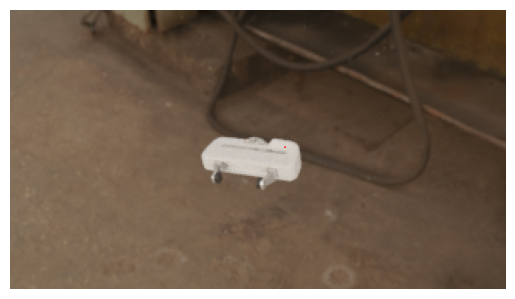

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

#print(cosine_sims.shape)

selectidx = 20    # 89似乎是一个匹配较好的位置
# >0.8 96

#point_cloud = np.array(matcher.model_pc.cpu())
point_cloud = ref_3d_coords[:,1:].cpu().numpy()

#rgb = F.interpolate(cropped_rgbs, size = (32, 32))[0].permute(1,2,0).cpu().numpy()
#rgb = ((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)) *255.0).astype(int)
#rgb[test_idxs[:][1].cpu()][test_idxs[:][2].cpu()] = np.array([255,0,0])
rgb = images[0, :3].permute(1, 2, 0).cpu().numpy() / 255.0 # H, W, 3
#print(test_2d_coords)
#rgb[test_2d_coords[:,1].cpu().numpy(), test_2d_coords[:,2].cpu().numpy()] = np.array([1,0,0])
rgb[test_2d_coords[selectidx,1].cpu().numpy(), test_2d_coords[selectidx,2].cpu().numpy()] = np.array([1,0,0])

#print(rgb)
fig = plt.figure()
plt.subplot(1,1, 1)
plt.imshow(rgb)
plt.axis('off')

heatmap = cosine_sims[selectidx].cpu()
#heatmap = heatmap/heatmap.max()
heatmap = torch.clip(heatmap, min=0, max=1)
point_color = np.zeros_like(point_cloud)
point_color[:,0] = heatmap
point_color[:,2] = 1-heatmap

print(point_cloud.shape, point_color.shape)
heat_mask = heatmap > 0
point_cloud = point_cloud[heat_mask]
point_color = point_color[heat_mask]

fig = go.Figure(data=[go.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # 调整节点的大小
        color=point_color,  # 给点云上色
        opacity=0.9
    )
)])
fig.update_layout(width=1000, height=1000)
fig.show()

In [25]:
torch.max(sim_field[:,230] - sim_field[:,550])  # 确实是不一样的，但是太不明显了

tensor(0.0118, device='cuda:0')